# Cooper & Cowan 2009

Was pointed at this paper by Zoltan Sylverster's talk here > https://www.youtube.com/watch?v=wxKhKSW4ZnQ

Gordon R. J. Cooper & Duncan R. Cowan (2009). Blocking geophysical borehole log data using the continuous wavelet transform. _Exploration Geophysics_, **40**, p233–236. [DOI: 10.1071/EG08127](https://doi.org/10.1071/EG08127).

The authors start with a synthetic log with boundaries at 20, 148, 190, and 255 m.

#### COMPLETELY DIFFERENT...

...but maybe also worth a try: [this paper](https://www.researchgate.net/profile/Michael-Small/publication/336251412_Fast_Automatic_Detection_of_Geological_Boundaries_from_Multivariate_Log_Data_Using_Recurrence/links/5e8e77d5299bf1307989da72/Fast-Automatic-Detection-of-Geological-Boundaries-from-Multivariate-Log-Data-Using-Recurrence.pdf), which has code: https://github.com/AyhamZaitouny/Boundaries-Detection-Weight-Quadrant-Scan- 

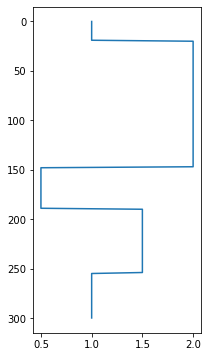

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_log(N, beds=None, default=1, levels=None):
    depth = np.linspace(0, N-1, N)
    log = np.ones(N) * default
    for t, b, level in zip(beds, beds[1:], levels):
        log[t:b] = level
    return log, depth


def plot(log, depth):
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.plot(log, depth)
    ax.invert_yaxis()
    return

log, depth = make_log(N=301,
                      beds=[20, 148, 190, 255],
                      levels=[2, 0.5, 1.5],
                      )

plot(log, depth)

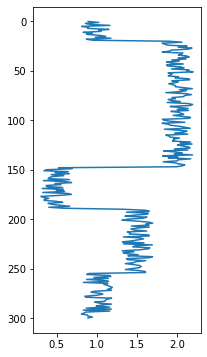

In [2]:
def add_noise(log, a=0.1):
    rng = np.random.default_rng(42)
    noise = a * (1 - 2 * rng.uniform(size=log.size))
    return log + noise

log = add_noise(log, a=0.2)

plot(log, depth)

## Median filter

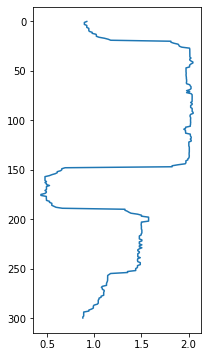

In [3]:
from scipy import ndimage

log_med = ndimage.median_filter(log, size=21)  # Figure 1b.

plot(log_med, depth)

## DWT

In [4]:
import pywt

cA, *_ = pywt.wavedec(log, wavelet='haar', level=4) # Figure 1d.

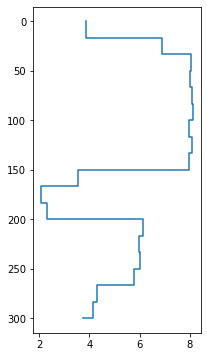

In [5]:
y = np.linspace(0, log.size-1, cA.size)

fig, ax = plt.subplots(figsize=(3, 6))
ax.step(cA, y)
ax.invert_yaxis()

## CWT

I don't quite understand the scale parameter in the paper... If I use `50` I get more scales than appear in Figure 1f.

### Using `scipy.signal.cwt()`

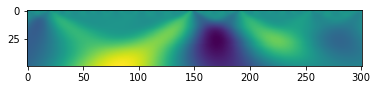

In [6]:
import scipy.signal as ss

# widths = np.logspace(0, 2, num=50)
widths = np.linspace(1, 50, num=50)

# if padding:
#     extra = int(widths.max() / 4)
#     signal = np.pad(log, pad_width=extra, mode='edge')
#     cwtmatr = ss.cwt(signal, ss.ricker, widths)
#     cwtmatr = cwtmatr[:, extra:-extra]

cwtmatr = ss.cwt(log-log.mean(), ss.ricker, widths)

plt.imshow(cwtmatr)

### Using `pywavelets`

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

Seems to be close to the `scipy` result.

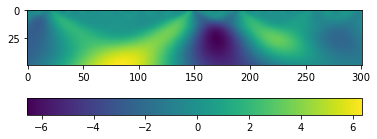

In [7]:
import pywt

cwtmatr_pywt, _ = pywt.cwt(log-log.mean(), widths, 'mexh')

plt.imshow(cwtmatr_pywt)
plt.colorbar(orientation='horizontal')

Difference:

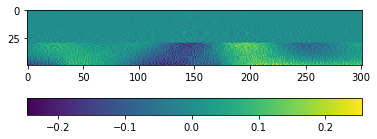

In [8]:
plt.imshow(cwtmatr - cwtmatr_pywt)
plt.colorbar(orientation='horizontal')

### Using `pycwt`

http://regeirk.github.io/pycwt/pycwt.html#pycwt.cwt

Probably more rigorous, but a bit too complex. Easier to apply other mother wavelets. Can't get linear scales, only log distribution.

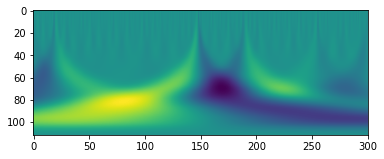

In [9]:
import pycwt

cwtmatr_pycwt, _, freqs, *_ = pycwt.cwt(log-log.mean(), dt=1, wavelet='mexicanhat')

plt.imshow(cwtmatr_pycwt.real)

### Viz

Let's use the `scipy` result.

Using the linear width distribution to match the paper, but implementation might want to use a log distribution? Maybe just makes things too complicated.

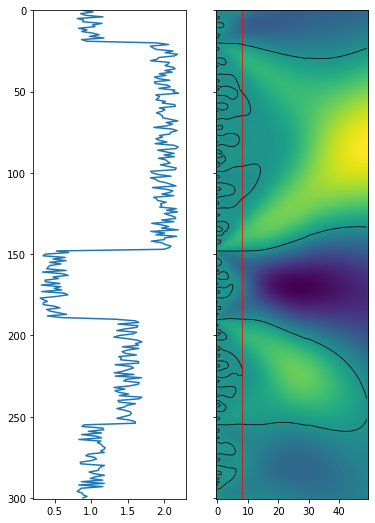

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 9), sharey=True)

axs[0].plot(log, depth)
axs[0].invert_yaxis()

axs[1].imshow(cwtmatr.T, aspect='auto')
contours = axs[1].contour(cwtmatr.T, levels=[0], linewidths=[0.75], colors='k')
axs[1].axvline(8, c='r', lw=0.75)
# axs[1].set_xscale('log')

## Extract contours

We want the boundaries at arbitrary scales... but we want their positions at a scale of 1. So we want to kind of trace them back, rather than taking them where they actually are, eg at a scale of 8. From the paper:

> The intersection points themselves are not used as the boundaries because their
position will vary depending on the scale that is chosen. Instead,
the location of the contour at a scale of 1 unit is used.

In [13]:
import matplotlib.path as pth

# Currently used as a global.
grad = np.sum(np.gradient(cwtmatr), axis=0)

def get_boundaries(contours, scale):
    target = pth.Path([[scale, 0], [scale, 300]])
    cands, amps = [], []
    for path in contours.collections[0].get_paths():
        if path.intersects_path(target):
            ends = path.vertices[path.vertices[:, 0]==0]
            for end in ends:
                cands.append([end[1], grad[1, int(end[1])]])
    return np.array(sorted(cands)).T

get_boundaries(contours, scale=18)

array([[ 20.07670635, 147.91977516, 190.18229503, 254.95532375],
       [  0.50398898,  -0.56943191,   0.60015596,  -0.36385132]])

## Demo

In [14]:
def block(log, tops):
    """Make a blocky log."""
    values = []
    tops = [None] + [int(t) for t in tops] + [None]
    for t, b in zip(tops, tops[1:]):
        values.append(np.nanmean(log[t:b]))
    return list(values) + [values[-1]]

In [27]:
from ipywidgets import interact

@interact(scale=(1, 50, 1))
def show(scale=10):
    fig, axs = plt.subplots(ncols=2, figsize=(6, 9), sharey=True)
    
    ax = axs[0]
    N = len(log)
    depth = np.linspace(0, N-1, N)
    ax.plot(log, depth)
    ax.invert_yaxis()
    
    ax = axs[1]
    ax.imshow(cwtmatr.T, aspect='auto')
    contours = ax.contour(cwtmatr.T, levels=[0], linewidths=[0.75], colors='k')
    cands, amps = get_boundaries(contours, scale=scale)
    ax.axvline(scale, c='r')
    
    values = block(log, cands)
    
    axs[0].step(values, [0] + list(cands) + [depth[-1]], lw=3)
    
    for cand, value in zip(cands, values[1:-1]):
        axs[0].axhline(cand, c='r')

interactive(children=(IntSlider(value=10, description='scale', max=50, min=1), Output()), _dom_classes=('widge…

## Boundary 'strength'

The zero-contour is on the 'second order' spectrum, apparently. The first order spectrum, whatever that is, gives the 'strength'. Not sure where that comes from.

Try integating:

In [16]:
cwtmatr.shape

(50, 301)

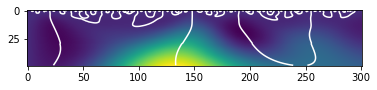

In [32]:
summ = np.cumsum(cwtmatr, axis=1)

plt.imshow(summ)
plt.contour(cwtmatr, levels=[0], colors='w')

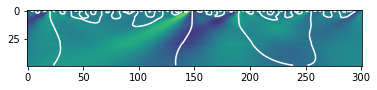

In [33]:
grad = np.sum(np.gradient(cwtmatr), axis=0)

plt.imshow(grad)
plt.contour(cwtmatr, levels=[0], colors='w')

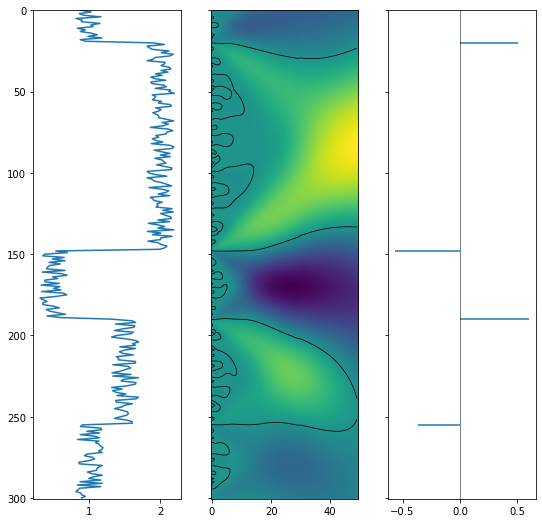

In [34]:
cands, amps = get_boundaries(contours, scale=18)

fig, axs = plt.subplots(ncols=3, figsize=(9, 9), sharey=True)

axs[0].plot(log, depth)
axs[0].invert_yaxis()

axs[1].imshow(cwtmatr.T, aspect='auto')
contours = axs[1].contour(cwtmatr.T, levels=[0], linewidths=[0.75], colors='k')

axs[2].hlines(cands, 0, amps)
axs[2].axvline(0, c='k', lw=0.5)

## Second log

Let's try adding another log. Not sure how to combine the information; will start with PCA.

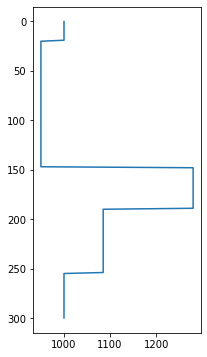

In [35]:
log2, _ = make_log(N=301,
                   default=1000,
                   beds=[20, 148, 190, 255],
                   levels=[950, 1280, 1085],
                   )

plot(log2, depth)

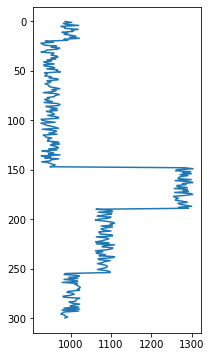

In [36]:
log2 = add_noise(log2, a=25)

plot(log2, depth)

Now we need to standardize:

In [64]:
def standardize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

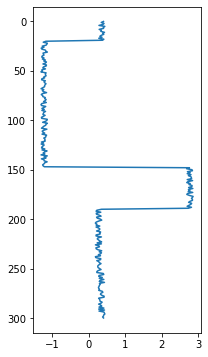

In [65]:
from sklearn.decomposition import PCA

logs = np.stack([log2, log]).T

logs_ = standardize(logs)

pca = PCA(n_components=1)
pca.fit(logs_)
log1 = np.squeeze(pca.transform(logs_))

plot(log1, depth)

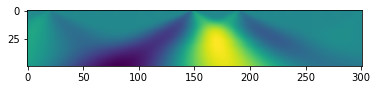

In [66]:
widths = np.linspace(1, 50, num=50)

cwtmatr1 = ss.cwt(log1-log1.mean(), ss.ricker, widths)

plt.imshow(cwtmatr1)

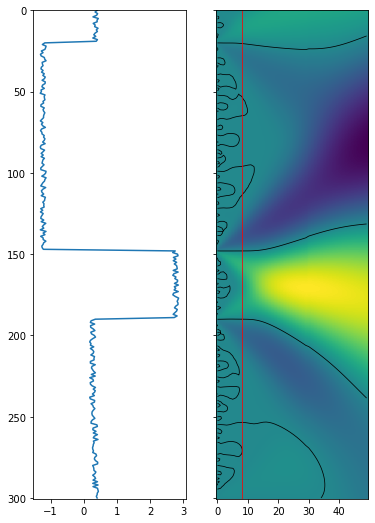

In [67]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 9), sharey=True)

axs[0].plot(log1, depth)
axs[0].invert_yaxis()

axs[1].imshow(cwtmatr1.T, aspect='auto')
contours1 = axs[1].contour(cwtmatr1.T, levels=[0], linewidths=[0.75], colors='k')
axs[1].axvline(8, c='r', lw=0.75)
# axs[1].set_xscale('log')

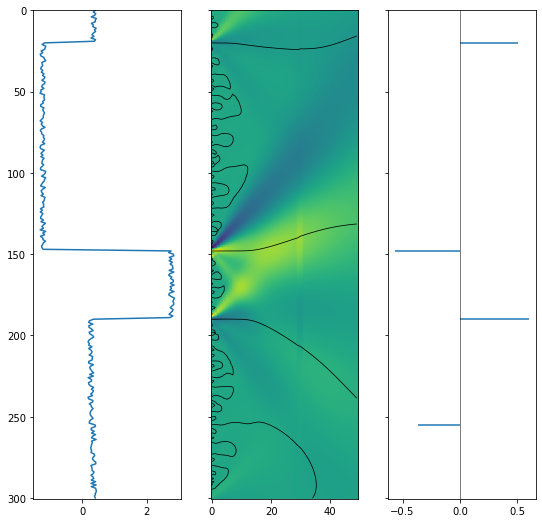

In [68]:
cands1, amps1 = get_boundaries(contours1, scale=18)
grad1 = np.sum(np.gradient(cwtmatr1), axis=0)

fig, axs = plt.subplots(ncols=3, figsize=(9, 9), sharey=True)

axs[0].plot(log1, depth)
axs[0].invert_yaxis()

axs[1].imshow(grad1.T, aspect='auto')
_ = axs[1].contour(cwtmatr1.T, levels=[0], linewidths=[0.75], colors='k')

axs[2].hlines(cands1, 0, amps1)
axs[2].axvline(0, c='k', lw=0.5)

---

&copy; 2022 Agile Scientific